# Main Telescope EFD Analysis

This notebook is based off of `../MTMount_EFDAnalysis.ipynb` and more detail is in there

This notebook seeks make histograms of MTMount velocity, acceleration, and jerk for long date ranges

This notebook extracts data from the DM-EFD using [aioinflux](https://aioinflux.readthedocs.io/en/stable/index.html), a Python client for InfluxDB, and proceed with data analysis using Pandas dataframes. 

This is complementaty to the [Chronograf](https://test-chronograf-efd.lsst.codes) interface which we use for time-series visualization.

In addition to `aioinflux`, you'll need to install `pandas`, `numpy` and `matplotlib` to run this notebook.

In [1]:
from matplotlib import pylab as plt
import aioinflux
import getpass
import pandas as pd
import asyncio
import numpy as np
from astropy.time import Time, TimeDelta

from lsst_efd_client import EfdClient, resample
from scipy.interpolate import interp1d
import math

In [2]:
# Change client if using USDF. 
client = EfdClient('usdf_efd')
client.output = 'dataframe'

We'll access the DM-EFD instance deployed at the summit. You need to be on site or connected to the NOAO VPN. 

## Declare timestamps used for EFD queries

In [3]:
### Example 
t1 = Time('2023-02-01T02:35:01', scale='utc') 
# window = TimeDelta(90*24*60*60, format='sec')
# t2=t1+window
### Example 
#t1 = Time('2022-12-00T02:35:01', scale='utc') 
#window = TimeDelta(4, format='sec')
#t2=t1+window
t2 = Time('2023-03-17T02:35:01', scale='utc') 


In [4]:
# time check verification
print(t1.isot)
print(t1.datetime64)
print(t2.isot)

2023-02-01T02:35:01.000
2023-02-01T02:35:01.000000000
2023-03-17T02:35:01.000


# Load EFD data
For this I have grabbed just the actualPosition and actualVelocity values for the alt and elevation encoders

For a larger query (longer time range) may want to run query as a script and load results.

See link for example query script in March 8th on #rubinobs-mtmount: https://lsstc.slack.com/archives/C047LHXRB4K/p1678251239301319

In [5]:
# Measured positions and velocities 
MTMount_Az = await client.select_time_series("lsst.sal.MTMount.azimuth", 
                                                  ["actualPosition","actualVelocity"], 
                                                  t1, t2)
MTMount_El = await client.select_time_series("lsst.sal.MTMount.elevation", ["actualPosition","actualVelocity"] ,t1, t2)
            

# Calculation of Acceleration/Jerk
Combine into single data frame

In [6]:
calculated_frame_el = pd.DataFrame({"time_el":MTMount_El.index,
                              "relative_time_el":(MTMount_El.index - MTMount_El.index[0]).total_seconds(),
                              "position_el":MTMount_El["actualPosition"].values,
                              "velocity_el":MTMount_El["actualVelocity"].values,
                              })

az_pos_interp=interp1d(calculated_frame_el["relative_time_el"], calculated_frame_el["position_el"], bounds_error=False)


calculated_frame_az = pd.DataFrame({"time_az":MTMount_Az.index,
                              "relative_time_az":(MTMount_Az.index - MTMount_Az.index[0]).total_seconds(),
                              "position_az":MTMount_Az["actualPosition"].values,
                              
                              })
calculated_frame_az["velocity_az"]=MTMount_Az["actualVelocity"].values * np.cos(np.radians(az_pos_interp(calculated_frame_az["relative_time_az"])))

calculated_frame_az["acceleration_az"] = np.gradient(calculated_frame_az["velocity_az"],
                                                    calculated_frame_az["relative_time_az"]) 
calculated_frame_az["jerk_az"] = np.gradient(calculated_frame_az["acceleration_az"],
                                            calculated_frame_az["relative_time_az"]) 


calculated_frame_el["acceleration_el"] = np.gradient(calculated_frame_el["velocity_el"],
                                                    calculated_frame_el["relative_time_el"]) 
calculated_frame_el["jerk_el"] = np.gradient(calculated_frame_el["acceleration_el"],
                                            calculated_frame_el["relative_time_el"]) 


calculated_frame_total = pd.DataFrame({"time_total":MTMount_Az.index,
                              "relative_time_total":(MTMount_Az.index - MTMount_Az.index[0]).total_seconds(),
                              
                              })
el_velocity_interp=interp1d(calculated_frame_el["relative_time_el"], calculated_frame_el["velocity_el"], bounds_error=False)
calculated_frame_total["theta"]=np.arctan(MTMount_Az["actualVelocity"].values/el_velocity_interp(calculated_frame_total["relative_time_total"].values))
calculated_frame_total["velocity_total"]=np.sqrt(calculated_frame_az["velocity_az"].values**2 +
                                                 el_velocity_interp(calculated_frame_total["relative_time_total"].values)**2)
calculated_frame_total["acceleration_total"]=np.gradient(calculated_frame_total["velocity_total"],
                                            calculated_frame_total["relative_time_total"]) 
calculated_frame_total["jerk_total"] = np.gradient(calculated_frame_total["acceleration_total"],
                                            calculated_frame_total["relative_time_total"]) 

calculated_frame=pd.concat([calculated_frame_az,calculated_frame_el, calculated_frame_total], axis=1)

/tmp/ipykernel_12788/91421449.py:34: RuntimeWarning: divide by zero encountered in true_divide
  calculated_frame_total["theta"]=np.arctan(MTMount_Az["actualVelocity"].values/el_velocity_interp(calculated_frame_total["relative_time_total"].values))
/tmp/ipykernel_12788/91421449.py:34: RuntimeWarning: invalid value encountered in true_divide
  calculated_frame_total["theta"]=np.arctan(MTMount_Az["actualVelocity"].values/el_velocity_interp(calculated_frame_total["relative_time_total"].values))


In [7]:
calculated_frame.head()

,time_az,relative_time_az,position_az,velocity_az,acceleration_az,jerk_az,time_el,relative_time_el,position_el,velocity_el,acceleration_el,jerk_el,time_total,relative_time_total,theta,velocity_total,acceleration_total,jerk_total
0,2023-02-01 02:39:31.390098+00:00,0.000000,-30.763489,-0.000003,-0.000075,-0.002273,2023-02-01 02:39:31.391543+00:00,0.000000,75.554306,-0.000103,0.002862,-0.018009,2023-02-01 02:39:31.390098+00:00,0.000000,0.106607,0.000103,-0.000660,0.013106
1,2023-02-01 02:39:31.448961+00:00,0.058863,-30.763489,-0.000007,-0.000209,0.000332,2023-02-01 02:39:31.449781+00:00,0.058238,75.554306,0.000063,0.001813,-0.026122,2023-02-01 02:39:31.448961+00:00,0.058863,-0.421694,0.000064,0.000112,0.004605
2,2023-02-01 02:39:31.504776+00:00,0.114678,-30.763489,-0.000026,-0.000052,0.004110,2023-02-01 02:39:31.506179+00:00,0.114636,75.554306,0.000108,-0.000103,-0.022723,2023-02-01 02:39:31.504776+00:00,0.114678,-0.763567,0.000111,-0.000081,-0.006338
3,2023-02-01 02:39:31.569075+00:00,0.178977,-30.763489,-0.000008,0.000309,-0.000493,2023-02-01 02:39:31.569903+00:00,0.178360,75.554306,0.000037,-0.000741,0.012301,2023-02-01 02:39:31.569075+00:00,0.178977,-0.731873,0.000038,-0.000702,0.010578
4,2023-02-01 02:39:31.648191+00:00,0.258093,-30.763489,0.000020,-0.000325,-0.004790,2023-02-01 02:39:31.649503+00:00,0.257960,75.554306,0.000016,0.002456,0.008614,2023-02-01 02:39:31.648191+00:00,0.258093,1.365459,0.000025,0.002105,0.006534


## Movement Histograms
See sitcom 710: https://jira.lsstcorp.org/browse/SITCOM-710 

- I think we just want full histograms for Alt, El, and (maybe total)
- I also *think* for total speed (velocity) we need a cos(elevation) factor, but havent fully thought that through
- I dont think position makes much sense here
- I also dont know that the limits are but was planning on marking those for each hist with vertical lines
- could remove the spike close to zero with a different sel_slew (2 cells below)

In [8]:
# setup for plotting 
mtypes=["az","el","total"]
color_dict={"total":"k",
            "az":"tab:red",
            "el":"tab:blue"}
label_dict={"total":"Total (speed)",
            "az": "Azmiuth",
            "el": "Elevation"}

In [9]:
# selecting only times where the telescope is slewing
sel_slew=(abs(calculated_frame["velocity_az"]) > 0.04) | (abs(calculated_frame["velocity_el"]) > 0.04)

In [10]:
# create sensible bin sizes to cover full range
vel_list=[]
acc_list=[]
jerk_list=[]
for i in mtypes:
    vel_list.append(calculated_frame[f"velocity_{i}"])
    acc_list.append(calculated_frame[f"acceleration_{i}"])
    jerk_list.append(calculated_frame[f"jerk_{i}"])
    


vel_bins=np.arange(np.nanmin(vel_list),np.nanmax(vel_list),0.5)
acc_bins=np.arange(np.nanmin(acc_list),np.nanmax(acc_list),0.1)
jerk_bins=np.arange(np.nanmin(jerk_list),np.nanmax(jerk_list),1)


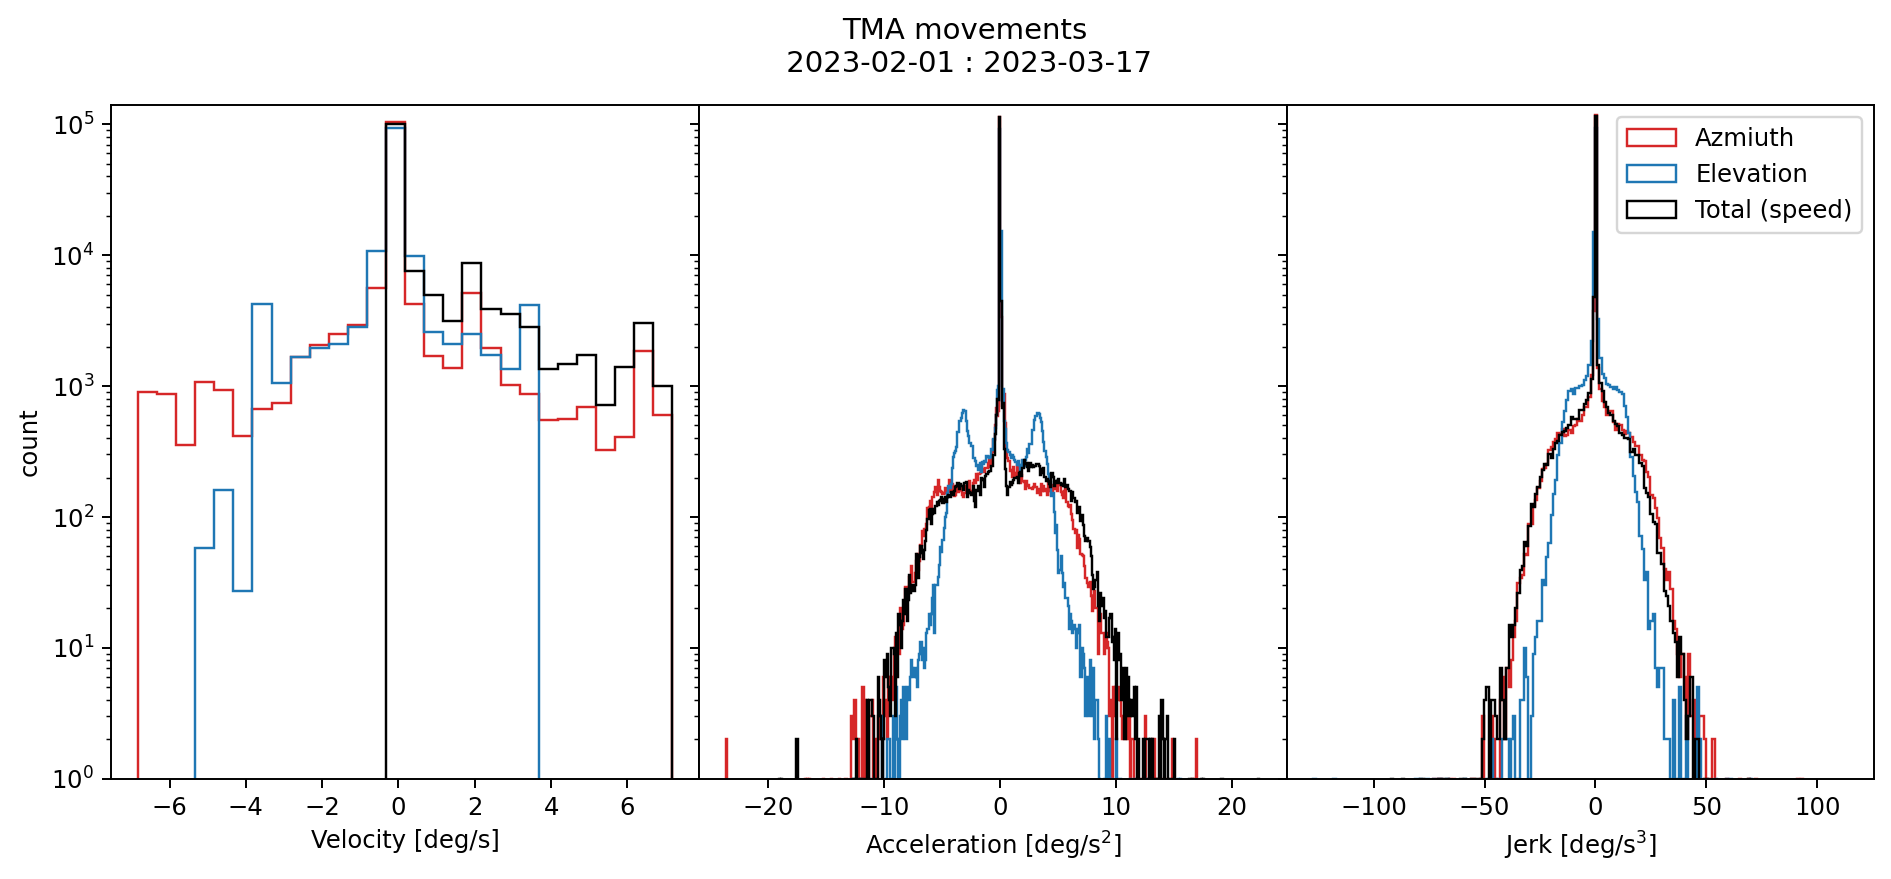

In [11]:
yMax=0

fig,axs=plt.subplots(1,3,dpi=175, figsize=(13,5))
plt.suptitle(f"TMA movements\n {t1.iso[:10]} : {t2.iso[:10]}")
for i in mtypes:
    velHist=axs[0].hist(calculated_frame[f"velocity_{i}"][sel_slew], 
                bins=vel_bins, histtype="step", color=color_dict[f"{i}"])
    yMax=np.max([yMax,np.max(velHist[0])])


axs[0].set_xlabel("Velocity [deg/s]")

for i in mtypes:
    accHist=axs[1].hist(calculated_frame[f"acceleration_{i}"][sel_slew], 
                bins=acc_bins, histtype="step", color=color_dict[i])
    yMax=np.max([yMax,np.max(accHist[0])])
        
axs[1].set_xlabel(r"Acceleration [deg/s$^2$]")

for i in mtypes:
    jerkHist=axs[2].hist(calculated_frame[f"jerk_{i}"][sel_slew], 
                bins=jerk_bins, histtype="step", color=color_dict[i], label=label_dict[i])
    yMax=np.max([yMax,np.max(jerkHist[0])])
        
axs[2].set_xlabel(r"Jerk [deg/s$^3$]")
axs[2].legend()

#yMax=10e5
for i in [0,1,2]:
    ax=axs[i]
    ax.set_yscale('log')
    ax.set_ylim(1e0,yMax * 1.2)
    if i > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("count")
plt.subplots_adjust(wspace=0)